# <span style="font-width:bold; font-size: 3rem; color:#333;">Training Pipeline</span>

## 🗒️ This notebook is divided into the following sections:

1. Select features for the model and create a Feature View with the selected features
2. Create training data using the feature view
3. Train model
4. Evaluate model performance
5. Save model to model registry

### <span style='color:#ff5f27'> 📝 Imports

In [1]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from functions import util

import warnings
warnings.filterwarnings("ignore")

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [4]:
# If you haven't set the env variable 'HOPSWORKS_API_KEY', then uncomment the next line and enter your API key
os.environ["HOPSWORKS_API_KEY"] = "cMbQxvfLOlU1g4pG.kw2Qm4g64D9Ngs50Eju8KYpTfU6SnRmRKbikreK9ioiBJu6rLrMdh1bWefmBt7rE"

project = hopsworks.login()
fs = project.get_feature_store() 

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1164444
Connected. Call `.close()` to terminate connection gracefully.


In [6]:
meta_csv_file="../../data/meta.csv"
meta_df = pd.read_csv(meta_csv_file, skipinitialspace=True)
meta_dict = {}
for row in meta_df.itertuples():
    meta_dict[row[2]] = {
        'Street' : row[2],
        'City' : row[3],
        'Country' : row[4],
        'Latitude' : row[5],
        'Longitude' : row[6],
        'aqicn_url' : row[7],
    }

meta_dict

{'Rosenlundsgatan': {'Street': 'Rosenlundsgatan',
  'City': 'Stockholm',
  'Country': 'Sweden',
  'Latitude': 59.31430493,
  'Longitude': 18.05700184,
  'aqicn_url': 'https://api.waqi.info/feed/A129124'},
 'Erstagatan': {'Street': 'Erstagatan',
  'City': 'Stockholm',
  'Country': 'Sweden',
  'Latitude': 59.31515153,
  'Longitude': 18.0901034,
  'aqicn_url': 'https://api.waqi.info/feed/A78022'},
 'Bellmansgatan': {'Street': 'Bellmansgatan',
  'City': 'Stockholm',
  'Country': 'Sweden',
  'Latitude': 59.32099927,
  'Longitude': 18.06445284,
  'aqicn_url': 'https://api.waqi.info/feed/A56749'},
 'Hornsgatan': {'Street': 'Hornsgatan',
  'City': 'Stockholm',
  'Country': 'Sweden',
  'Latitude': 59.31711415,
  'Longitude': 18.04826249,
  'aqicn_url': 'https://api.waqi.info/feed/@10009'}}

In [8]:
# Retrieve feature groups
for key, inner_dict in meta_dict.items():
    inner_dict['air_quality_fg'] = fs.get_feature_group(
        name='air_quality_' + inner_dict['Street'].lower(),
        version=1,
    )
    inner_dict['weather_fg'] = fs.get_feature_group(
        name='weather_' + inner_dict['Street'].lower(),
        version=1,
    )
meta_dict

{'Rosenlundsgatan': {'Street': 'Rosenlundsgatan',
  'City': 'Stockholm',
  'Country': 'Sweden',
  'Latitude': 59.31430493,
  'Longitude': 18.05700184,
  'aqicn_url': 'https://api.waqi.info/feed/A129124',
  'air_quality_fg': <hsfs.feature_group.FeatureGroup at 0x224aa0bf6d0>,
  'weather_fg': <hsfs.feature_group.FeatureGroup at 0x224aa0bf5d0>},
 'Erstagatan': {'Street': 'Erstagatan',
  'City': 'Stockholm',
  'Country': 'Sweden',
  'Latitude': 59.31515153,
  'Longitude': 18.0901034,
  'aqicn_url': 'https://api.waqi.info/feed/A78022',
  'air_quality_fg': <hsfs.feature_group.FeatureGroup at 0x224abb5b010>,
  'weather_fg': <hsfs.feature_group.FeatureGroup at 0x224abd9bc10>},
 'Bellmansgatan': {'Street': 'Bellmansgatan',
  'City': 'Stockholm',
  'Country': 'Sweden',
  'Latitude': 59.32099927,
  'Longitude': 18.06445284,
  'aqicn_url': 'https://api.waqi.info/feed/A56749',
  'air_quality_fg': <hsfs.feature_group.FeatureGroup at 0x224abd6f490>,
  'weather_fg': <hsfs.feature_group.FeatureGroup at

--- 

## <span style="color:#ff5f27;"> 🖍 Feature View Creation and Retrieving </span>

In [11]:
# Select features for training data.
for key, inner_dict in meta_dict.items():
    inner_dict['selected_features'] = inner_dict['air_quality_fg'].select(['pm25']).join(inner_dict['weather_fg'].select_all(), on=['city'])
    inner_dict['selected_features'].show(10)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.41s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.35s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.89s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.46s) 


In [13]:
meta_dict['Hornsgatan']['selected_features'].show(10)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.34s) 


,pm25,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,13.0,2017-10-04 00:00:00+00:00,10.483834,3.000000,21.603001,246.287766,Stockholm
1,9.0,2017-10-05 00:00:00+00:00,8.485917,2.200000,15.856354,305.453735,Stockholm
2,8.0,2017-10-06 00:00:00+00:00,8.294250,0.500000,22.127556,321.105164,Stockholm
3,13.0,2017-10-07 00:00:00+00:00,5.850500,5.800001,12.661564,345.645691,Stockholm
4,8.0,2017-10-08 00:00:00+00:00,6.254667,19.499998,25.630886,338.677063,Stockholm
5,7.0,2017-10-09 00:00:00+00:00,8.052584,13.300000,21.602999,0.798263,Stockholm
6,12.0,2017-10-10 00:00:00+00:00,6.900501,0.100000,20.658480,308.978394,Stockholm
7,12.0,2017-10-11 00:00:00+00:00,6.925500,1.800000,12.722830,271.928833,Stockholm
8,10.0,2017-10-12 00:00:00+00:00,10.002584,12.400000,19.914217,212.783020,Stockholm
9,9.0,2017-10-13 00:00:00+00:00,7.775500,3.100000,25.264202,325.661865,Stockholm


### Feature Views

`Feature Views` are selections of features from different **Feature Groups** that make up the input and output API (or schema) for a model. A **Feature Views** can create **Training Data** and also be used in Inference to retrieve inference data.

The Feature Views allows a schema in form of a query with filters, defining a model target feature/label and additional transformation functions (declarative feature encoding).

In order to create Feature View we can use `FeatureStore.get_or_create_feature_view()` method.

You can specify the following parameters:

- `name` - name of a feature group.

- `version` - version of a feature group.

- `labels`- our target variable.

- `transformation_functions` - declarative feature encoding (not used here)

- `query` - selected features/labels for the model 

In [16]:
for key, inner_dict in meta_dict.items():
    inner_dict['feature_view'] = fs.get_or_create_feature_view(
        name='air_quality_fv_' + inner_dict['Street'].lower(),
        description="weather features with air quality as the target",
        version=1,
        labels=['pm25'],
        query=inner_dict['selected_features'],
    )

meta_dict

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1164444/fs/1155147/fv/air_quality_fv_rosenlundsgatan/version/1
Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1164444/fs/1155147/fv/air_quality_fv_erstagatan/version/1
Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1164444/fs/1155147/fv/air_quality_fv_bellmansgatan/version/1
Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1164444/fs/1155147/fv/air_quality_fv_hornsgatan/version/1


{'Rosenlundsgatan': {'Street': 'Rosenlundsgatan',
  'City': 'Stockholm',
  'Country': 'Sweden',
  'Latitude': 59.31430493,
  'Longitude': 18.05700184,
  'aqicn_url': 'https://api.waqi.info/feed/A129124',
  'air_quality_fg': <hsfs.feature_group.FeatureGroup at 0x224aa0bf6d0>,
  'weather_fg': <hsfs.feature_group.FeatureGroup at 0x224aa0bf5d0>,
  'selected_features': <hsfs.constructor.query.Query at 0x224ab80e090>,
  'feature_view': <hsfs.feature_view.FeatureView at 0x224abdf0dd0>},
 'Erstagatan': {'Street': 'Erstagatan',
  'City': 'Stockholm',
  'Country': 'Sweden',
  'Latitude': 59.31515153,
  'Longitude': 18.0901034,
  'aqicn_url': 'https://api.waqi.info/feed/A78022',
  'air_quality_fg': <hsfs.feature_group.FeatureGroup at 0x224abb5b010>,
  'weather_fg': <hsfs.feature_group.FeatureGroup at 0x224abd9bc10>,
  'selected_features': <hsfs.constructor.query.Query at 0x224abe61350>,
  'feature_view': <hsfs.feature_view.FeatureView at 0x224abdc4790>},
 'Bellmansgatan': {'Street': 'Bellmansgata

## <span style="color:#ff5f27;">🪝 Split the training data into train/test data sets </span>

We use a time-series split here, with training data before this date `start_date_test_data` and test data after this date

In [19]:
start_date_test_data = "2024-03-01"
# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [21]:
for key, inner_dict in meta_dict.items():
    X_train, X_test, y_train, y_test = inner_dict['feature_view'].train_test_split(
        test_start=test_start
    )
    inner_dict['X_train'] = X_train
    inner_dict['X_test'] = X_test
    inner_dict['y_train'] = y_train
    inner_dict['y_test'] = y_test

meta_dict

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.24s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.27s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.20s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.47s) 


{'Rosenlundsgatan': {'Street': 'Rosenlundsgatan',
  'City': 'Stockholm',
  'Country': 'Sweden',
  'Latitude': 59.31430493,
  'Longitude': 18.05700184,
  'aqicn_url': 'https://api.waqi.info/feed/A129124',
  'air_quality_fg': <hsfs.feature_group.FeatureGroup at 0x224aa0bf6d0>,
  'weather_fg': <hsfs.feature_group.FeatureGroup at 0x224aa0bf5d0>,
  'selected_features': <hsfs.constructor.query.Query at 0x224ab80e090>,
  'feature_view': <hsfs.feature_view.FeatureView at 0x224abdf0dd0>,
  'X_train':                            date  temperature_2m_mean  precipitation_sum  \
  0     2020-07-06 00:00:00+00:00            15.356167                0.4   
  1     2020-07-07 00:00:00+00:00            14.670753                0.3   
  2     2020-07-08 00:00:00+00:00            11.479084                4.1   
  3     2020-07-09 00:00:00+00:00            14.112416                0.6   
  4     2020-07-10 00:00:00+00:00            13.814500                3.4   
  ...                         ...          

In [8]:
X_train

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2018-04-28 00:00:00+00:00,27.305830,1.000000,9.693296,102.002296,jakarta
1,2018-04-30 00:00:00+00:00,27.549582,0.000000,15.815435,89.438301,jakarta
2,2018-05-03 00:00:00+00:00,26.880829,4.300000,11.298495,103.240654,jakarta
3,2018-05-04 00:00:00+00:00,27.226664,0.000000,10.144082,127.875076,jakarta
4,2018-05-05 00:00:00+00:00,28.007914,0.100000,14.400000,85.110931,jakarta
...,...,...,...,...,...,...
1509,2024-02-25 00:00:00+00:00,26.241243,23.400003,17.193533,310.963806,jakarta
1510,2024-02-26 00:00:00+00:00,27.376665,13.299999,15.256526,358.622925,jakarta
1511,2024-02-27 00:00:00+00:00,27.072495,18.300001,13.009903,315.179565,jakarta
1512,2024-02-28 00:00:00+00:00,26.078749,12.800001,8.373386,280.988586,jakarta


In [23]:
# Drop the index columns - 'date' (event_time) and 'city' (primary key)
for key, inner_dict in meta_dict.items():
    inner_dict['train_features'] = inner_dict['X_train'].drop(['date', 'city'], axis=1)
    inner_dict['test_features'] = inner_dict['X_test'].drop(['date', 'city'], axis=1)

In [29]:
meta_dict

{'Rosenlundsgatan': {'Street': 'Rosenlundsgatan',
  'City': 'Stockholm',
  'Country': 'Sweden',
  'Latitude': 59.31430493,
  'Longitude': 18.05700184,
  'aqicn_url': 'https://api.waqi.info/feed/A129124',
  'air_quality_fg': <hsfs.feature_group.FeatureGroup at 0x258ee3e4a90>,
  'weather_fg': <hsfs.feature_group.FeatureGroup at 0x258ee35eb10>,
  'selected_features': <hsfs.constructor.query.Query at 0x258ee3e9010>,
  'feature_view': <hsfs.feature_view.FeatureView at 0x258efd82c10>,
  'X_train':                            date  temperature_2m_mean  precipitation_sum  \
  0     2020-07-06 00:00:00+00:00            15.356167                0.4   
  1     2020-07-07 00:00:00+00:00            14.670753                0.3   
  2     2020-07-08 00:00:00+00:00            11.479084                4.1   
  3     2020-07-09 00:00:00+00:00            14.112416                0.6   
  4     2020-07-10 00:00:00+00:00            13.814500                3.4   
  ...                         ...          

The `Feature View` is now saved in Hopsworks and you can retrieve it using `FeatureStore.get_feature_view(name='...', version=1)`.

---

## <span style="color:#ff5f27;">🧬 Modeling</span>

We will train a regression model to predict pm25 using our 4 features (wind_speed, wind_dir, temp, precipitation)

In [25]:
# Creating an instance of the XGBoost Regressor
for key, inner_dict in meta_dict.items():
    inner_dict['xgb_regressor'] = XGBRegressor()

# Fitting the XGBoost Regressor to the training data
    inner_dict['xgb_regressor'].fit(inner_dict['train_features'], inner_dict['y_train'])


In [27]:
for key, inner_dict in meta_dict.items():
# Predicting target values on the test set
    inner_dict['y_pred'] = inner_dict['xgb_regressor'].predict(inner_dict['test_features'])

# Calculating Mean Squared Error (MSE) using sklearn
    inner_dict['mse'] = mean_squared_error(inner_dict['y_test'].iloc[:,0], inner_dict['y_pred'])
    print("MSE:", inner_dict['mse'])

# Calculating R squared using sklearn
    inner_dict['r2'] = r2_score(inner_dict['y_test'].iloc[:,0], inner_dict['y_pred'])
    print("R squared:", inner_dict['r2'])

MSE: 6.649015
R squared: -18.612190629088918
MSE: 11.451134
R squared: -0.46584909364134597
MSE: 10.403417
R squared: -0.5203184602526412
MSE: 174.56635
R squared: -0.12010293144831241


In [29]:
for key, inner_dict in meta_dict.items():
    inner_dict['df'] = inner_dict['y_test']
    inner_dict['df']['predicted_pm25'] = inner_dict['y_pred']

In [31]:
for key, inner_dict in meta_dict.items():
    inner_dict['df']['date'] = inner_dict['X_test']['date']
    inner_dict['df'] = inner_dict['df'].sort_values(by=['date'])
    inner_dict['df'].head(5)

In [33]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "air_quality_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

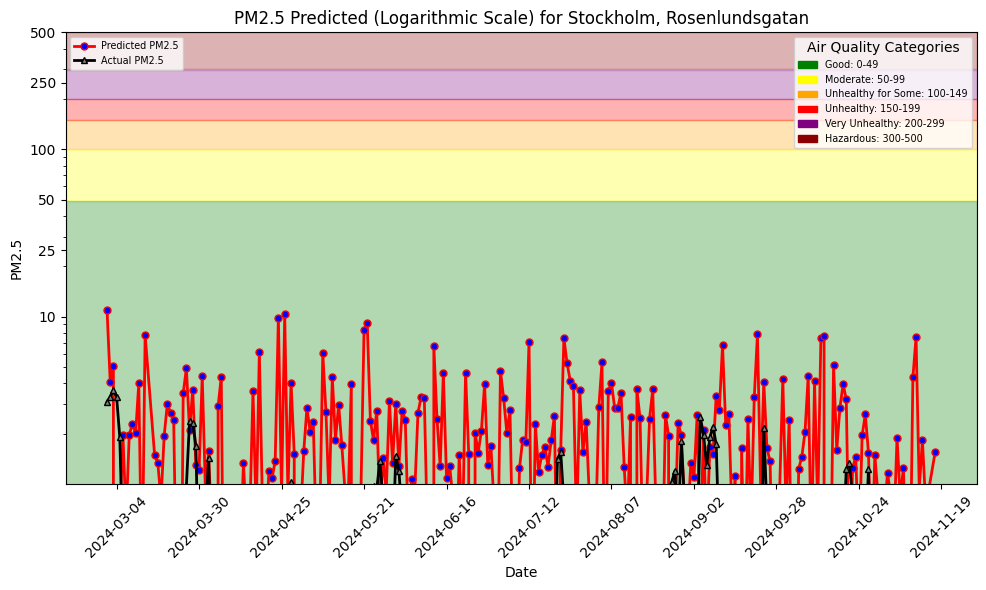

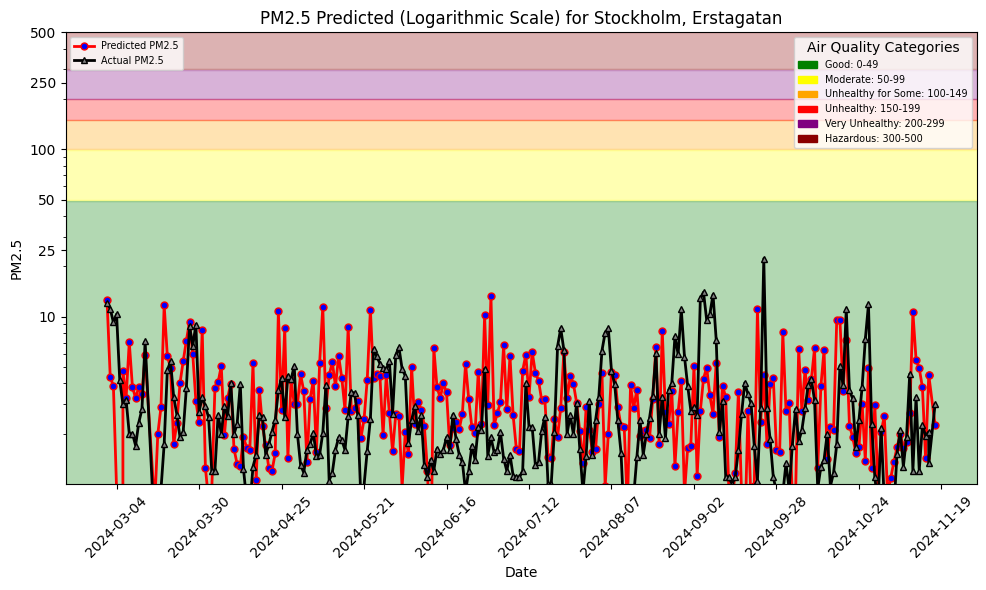

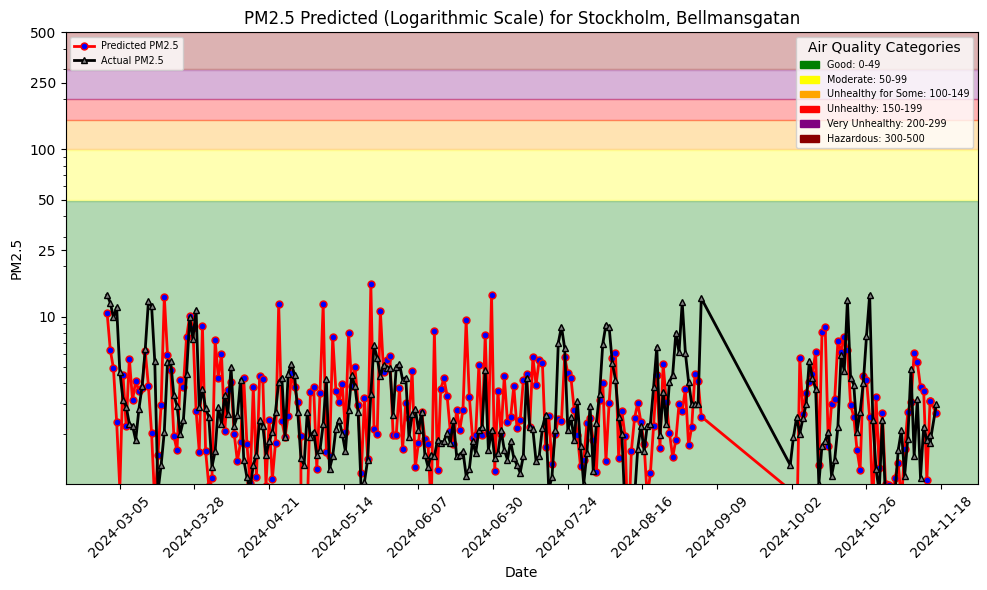

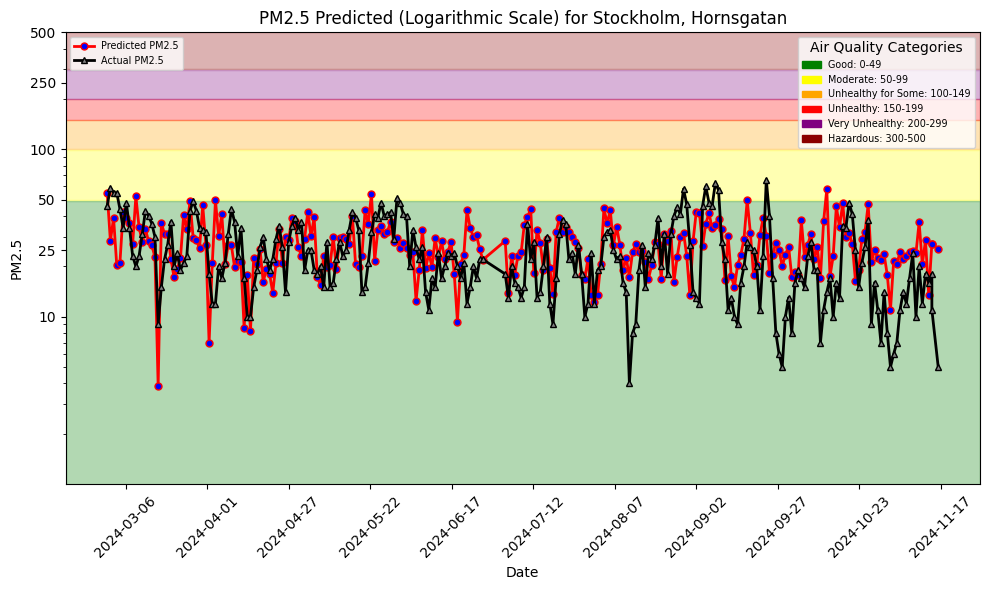

In [35]:
for key, inner_dict in meta_dict.items():
    file_path = images_dir + "/pm25_hindcast_" + inner_dict['Street'].lower() +".png"
    plt = util.plot_air_quality_forecast(inner_dict['City'], inner_dict['Street'], inner_dict['df'], file_path, hindcast=True) 
    plt.show()

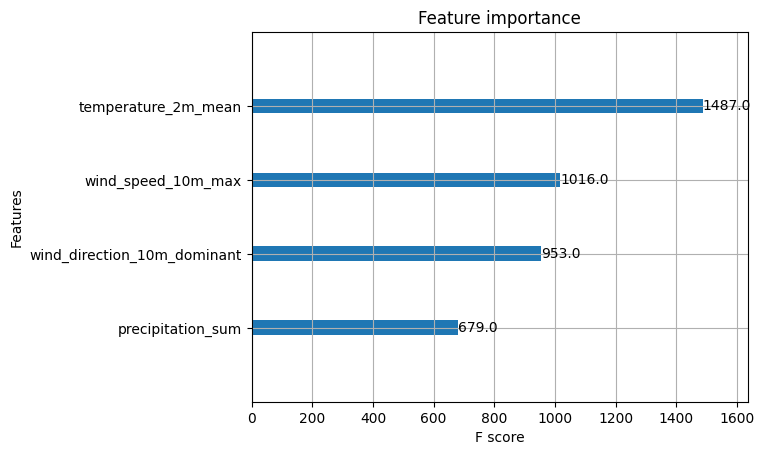

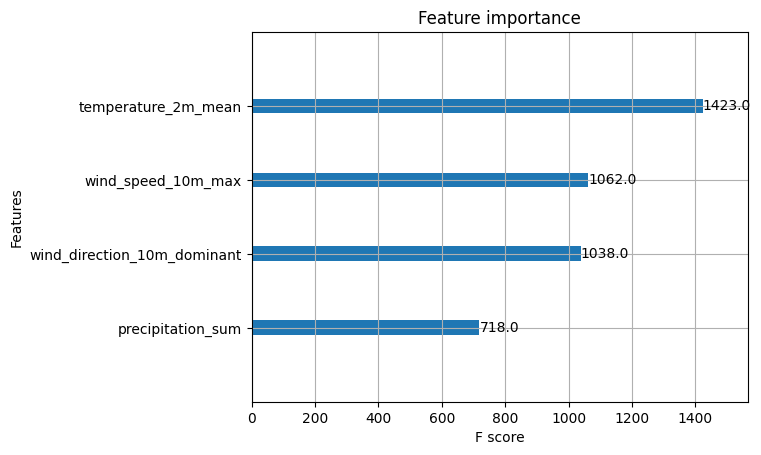

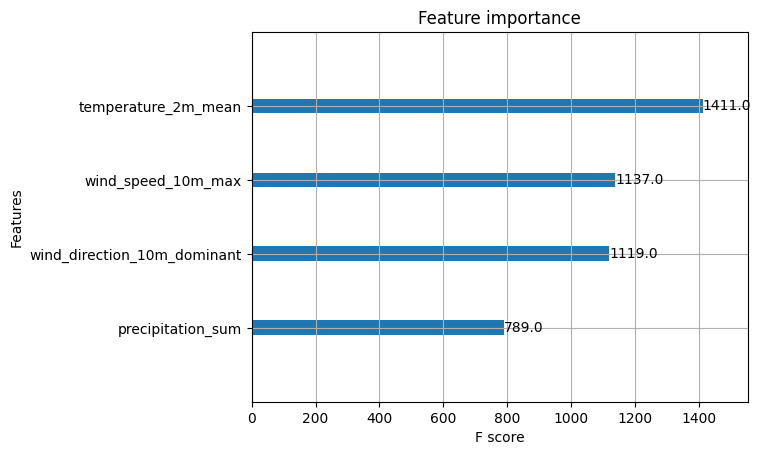

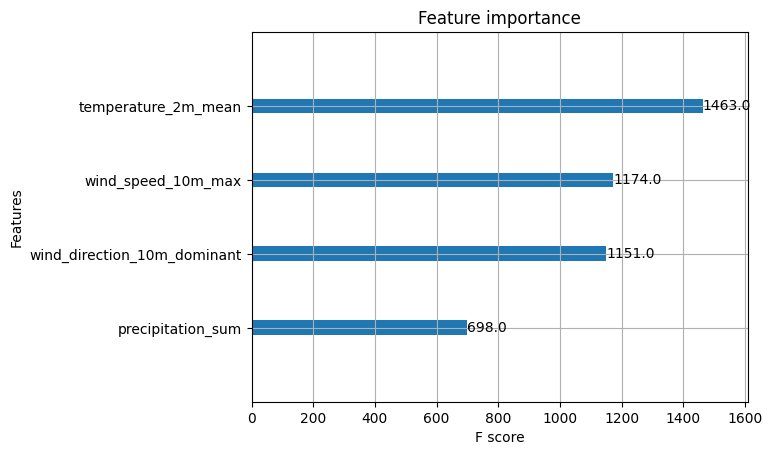

In [37]:
for key, inner_dict in meta_dict.items():
    # Plotting feature importances using the plot_importance function from XGBoost
    plot_importance(inner_dict['xgb_regressor'], max_num_features=4)
    feature_importance_path = images_dir + "/feature_importance_" + inner_dict['Street'].lower() + ".png"
    plt.savefig(feature_importance_path)
    plt.show()

---

## <span style='color:#ff5f27'>🗄 Model Registry</span>

One of the features in Hopsworks is the model registry. This is where you can store different versions of models and compare their performance. Models from the registry can then be served as API endpoints.

### <span style="color:#ff5f27;">⚙️ Model Schema</span>

The model needs to be set up with a [Model Schema](https://docs.hopsworks.ai/machine-learning-api/latest/generated/model_schema/), which describes the inputs and outputs for a model.

A Model Schema can be automatically generated from training examples, as shown below.

In [43]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

for key, inner_dict in meta_dict.items():
    # Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
    inner_dict['input_schema'] = Schema(inner_dict['X_train'])
    inner_dict['output_schema'] = Schema(inner_dict['y_train'])

# Creating a model schema using 'ModelSchema' with the input and output schemas
    inner_dict['model_schema'] = ModelSchema(input_schema=inner_dict['input_schema'], output_schema=inner_dict['output_schema'])

# Converting the model schema to a dictionary representation
    inner_dict['schema_dict'] = inner_dict['model_schema'].to_dict()

In [45]:
# Saving the XGBoost regressor object as a json file in the model directory
for key, inner_dict in meta_dict.items():
    inner_dict['xgb_regressor'].save_model(model_dir + "/model_" + inner_dict['Street'].lower() + ".json")

In [47]:
for key, inner_dict in meta_dict.items():
    inner_dict['res_dict'] = { 
            "MSE": str(inner_dict['mse']),
            "R squared": str(inner_dict['r2']),
        }

In [49]:
for key, inner_dict in meta_dict.items():
    print("__________________________________")
    inner_dict['mr'] = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

    inner_dict['aq_model'] = inner_dict['mr'].python.create_model(
        name="air_quality_xgboost_model_" + inner_dict['Street'].lower(), 
        metrics= inner_dict['res_dict'],
        model_schema= inner_dict['model_schema'],
        input_example=inner_dict['X_test'].sample().values, 
        description="Air Quality (PM2.5) predictor",
    )

    # Saving the model artifacts to the 'air_quality_model' directory in the model registry
    inner_dict['aq_model'].save(model_dir + "/model_" + inner_dict['Street'].lower() + ".json")

__________________________________
Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/480744 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/108 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/682 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1164444/models/air_quality_xgboost_model_rosenlundsgatan/1
__________________________________
Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/492132 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/107 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/682 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1164444/models/air_quality_xgboost_model_erstagatan/1
__________________________________
Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/515186 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/104 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/682 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1164444/models/air_quality_xgboost_model_bellmansgatan/1
__________________________________
Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/512190 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/108 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/682 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1164444/models/air_quality_xgboost_model_hornsgatan/1


---
## <span style="color:#ff5f27;">⏭️ **Next:** Part 04: Batch Inference</span>

In the following notebook you will use your model for Batch Inference.
